In [2]:
import sys
sys.path.insert(0,'..')

from src.definitions import *
from src.plotting import *
from src.processing import *
from src.stats import *
from src.figures import *
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
from scipy import signal
from datetime import datetime, timedelta
import scipy as sp
from scipy import io, signal
import pytz
import plotly.graph_objects as go

from src.definitions import *
from src.plotting import *
from src.processing import *
from src.stats import *
from src.figures import *

evi_blue = '#34599E'
evi_green = '#4EB792'
evi_yellow = '#F4C15D'
evi_orange = '#EC8C46'
evi_purple = '#823266'
evi_gray = '#C5C5C5'

def get_normalization_scalers(df, field):
    ddf = df.copy()
    ddf['min'] = ddf.groupby('participant_id')[field].transform(min)
    ddf['max'] = ddf.groupby('participant_id')[field].transform(max)
    ddf['mean'] = ddf.groupby('participant_id')[field].transform(lambda x: np.mean(x))
    ddf['std'] = ddf.groupby('participant_id')[field].transform(lambda x: np.std(x))
    return ddf['min'], ddf['max'], ddf['mean'], ddf['std']

def add_rolling_mean_and_std(df, field):
    df['rolling_' + field] = df.groupby('participant_id')[field].rolling(7).mean().shift(-3).reset_index(0,drop=True)
    df['rolling_' + field + '_std'] = df.groupby('participant_id')[field].rolling(7).std().shift(-3).reset_index(0,drop=True)
    df['rolling_'+ field + '_plus'] = df['rolling_' + field] + df['rolling_' + field + '_std']/2
    df['rolling_'+ field + '_minus'] = df['rolling_' + field] - df['rolling_' + field + '_std']/2
    
    a, b, m, s = get_normalization_scalers(df, 'rolling_' + field)
    df['z_rolling_' + field] = (df['rolling_' + field] - m)/s
    df['z_rolling_' + field + '_std'] = df['rolling_' + field + '_std']/s
    df['z_rolling_' + field + '_plus'] = df['z_rolling_' + field] + df['z_rolling_' + field + '_std']/2
    df['z_rolling_' + field + '_minus'] = df['z_rolling_' + field] - df['z_rolling_' + field + '_std']/2
    return df

def interpolate(x):
    values_with_nas = np.array(pd.Series(x).replace(0, np.nan).interpolate(limit_area='inside'))
    return values_with_nas[~np.isnan(values_with_nas)]

def get_period(s):
    # s: signal, daily timeseries
    # returns:
    # freq: peak frequency
    # period = 1/freq
    # freqs
    # fft
    try:
        s = interpolate(s)
        fs = 1
        freqs = np.fft.rfftfreq(len(s), 1/fs)
        fft = np.abs(np.fft.rfft(s))

        freq = freqs[np.argmax(fft)]
        period = 1/freq
        
        return freq, period, freqs, fft
    except:
        return None, None, None, None

## Read data

In [3]:
df = load_sleep_daily()
df = df[['participant_id', 'summary_date', 'hr_average', 'rmssd', 'breath_average', 'duration', 'temperature_delta', "daily_stressed", "daily_shifts"]]
df['date'] = pd.to_datetime(df.summary_date).dt.date
df['HR'] = df.hr_average
df['HRV'] = df.rmssd
df['RR'] = df.breath_average
df['temperature'] = df.temperature_delta
df['stress'] = df.daily_stressed
df['shifts'] = df.daily_shifts

## Compute rolling means, stds, and normalizations

In [4]:
df = add_rolling_mean_and_std(df, 'HR')
df = add_rolling_mean_and_std(df, 'HRV')
df = add_rolling_mean_and_std(df, 'RR')
df = add_rolling_mean_and_std(df, 'temperature')
df = add_rolling_mean_and_std(df, 'duration')
df = add_rolling_mean_and_std(df, 'stress')
df = add_rolling_mean_and_std(df, 'shifts')

## Add demographics info

In [5]:
dem_df = load_once()
dem_df = dem_df.dropna(subset=['dem_gender'])
dem_df['gender'] = dem_df.dem_gender.apply(lambda x: ['female', 'male', 'non-binary', 'other', 'prefer not to say'][int(x)-1])
dem_df['age'] = dem_df.dem_age
df = df.merge(dem_df[['participant_id', 'gender', 'age']], on='participant_id')

In [6]:
gdf = df.groupby('participant_id').date.nunique().reset_index()
gdf = gdf.loc[gdf.date >= 90]

In [7]:
participants = gdf.participant_id.unique()
males = df.loc[(df.participant_id.isin(participants)) & (df.gender == 'male')].participant_id.unique()
females = df.loc[(df.participant_id.isin(participants)) & (df.gender == 'female')].participant_id.unique()

In [8]:
df = df.loc[df.participant_id.isin(participants)]

## Select a participant and draw signals (HR, HRV, RR, temp) and their rolling mean over time

Participant 1 - Sex female - Age 32.0
Evolution of HR over study period


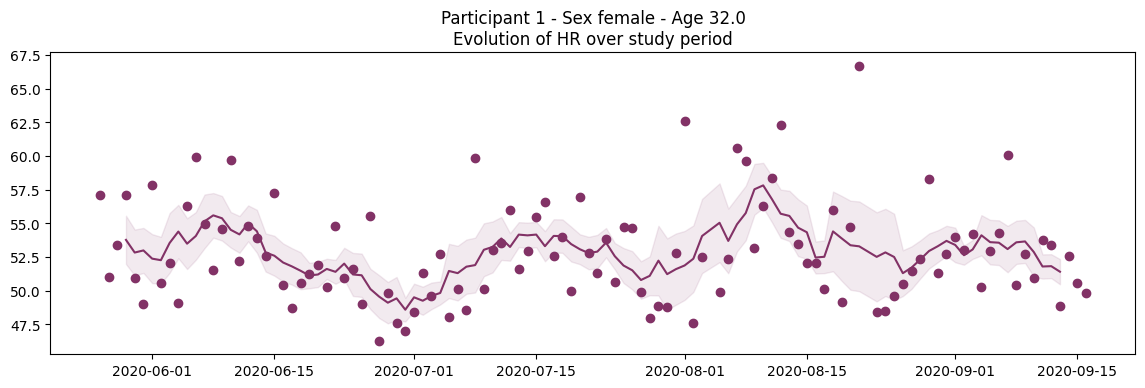

Evolution of HRV over study period


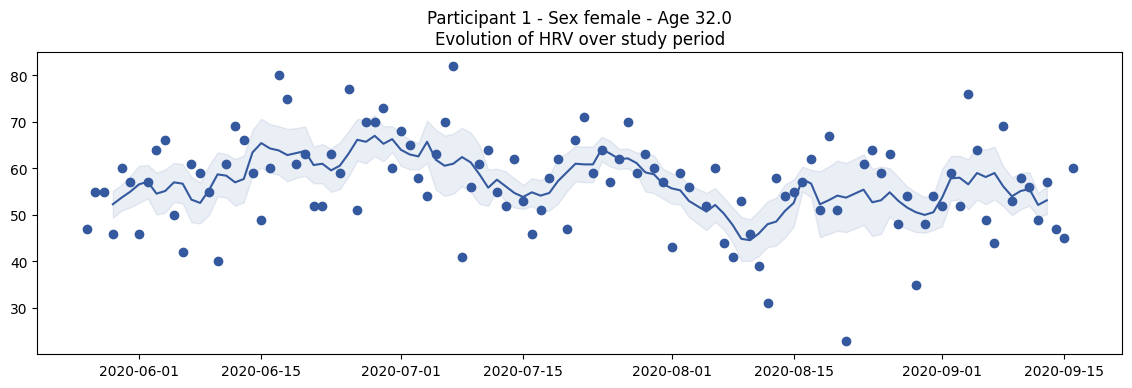

Evolution of RR over study period


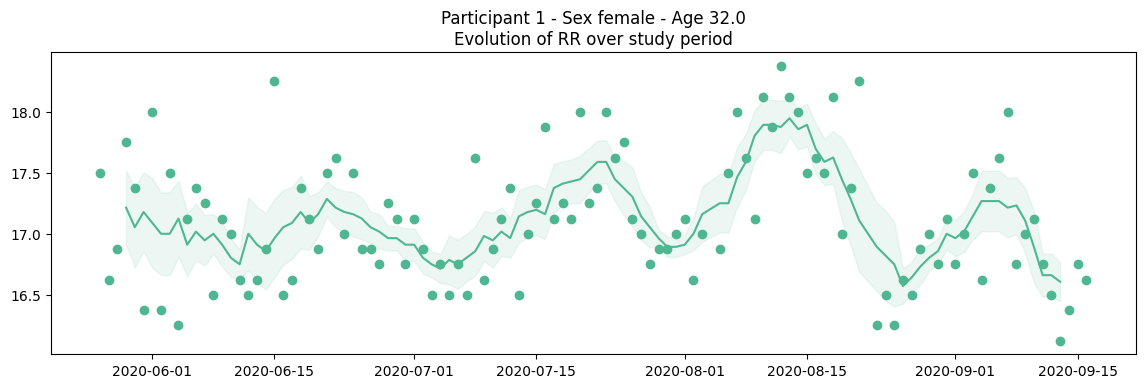

Evolution of temperature over study period


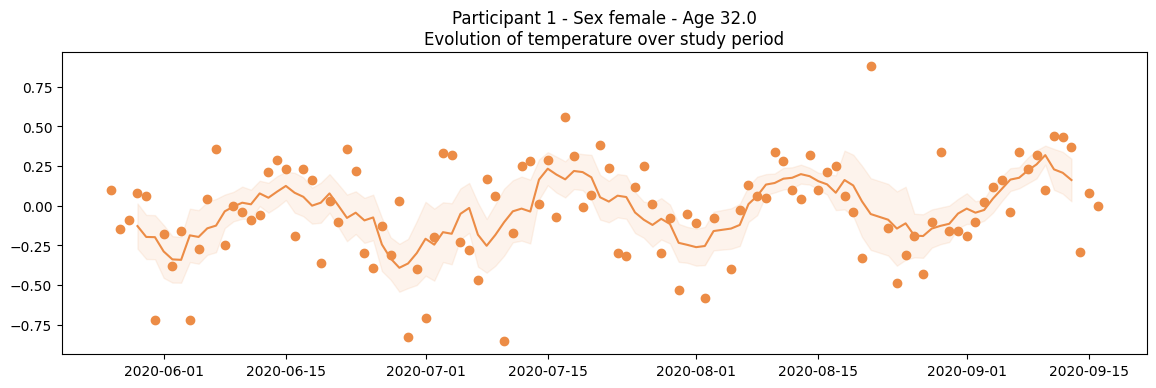

Evolution of stress over study period


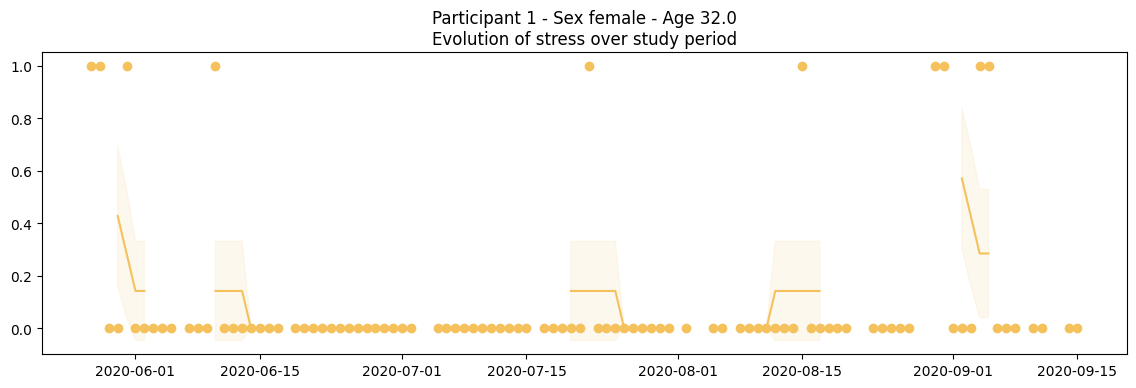

Evolution of shifts over study period


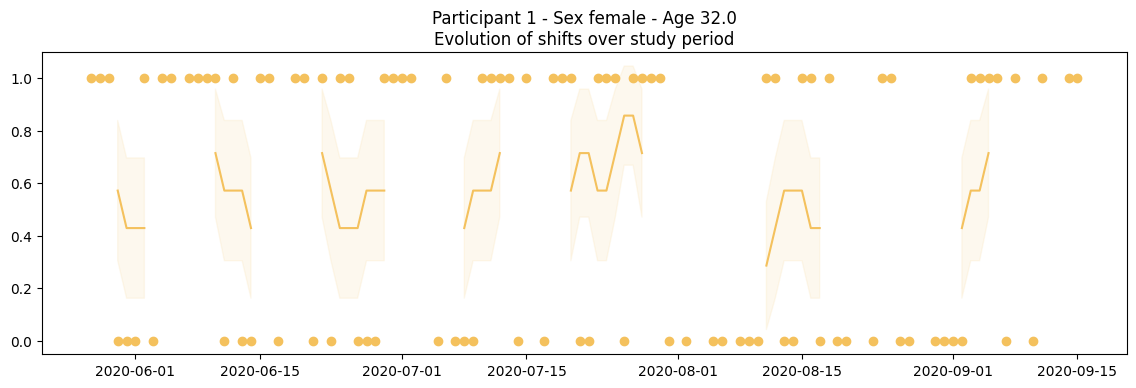

In [9]:
k = 1
participant = participants[k]
#participant = 'U-MQD4QADLZXH4WLR1J5XC'

pdf = df.loc[df.participant_id == participant]
gender = pdf.gender.values[0]
age = pdf.age.values[0]

print(f'Participant {k} - Sex {gender} - Age {age}')

fields = ['HR', 'HRV', 'RR', 'temperature', "stress", "shifts"]
colors = {
    'HR': evi_purple, 'HRV': evi_blue, 'RR': evi_green, 'temperature': evi_orange, "stress": evi_yellow, "shifts": evi_yellow
}

i = 0
field = fields[i]
for field in fields:
    color = colors[field]
    print(f'Evolution of {field} over study period')
    plt.figure(figsize=(14, 4), dpi=100)
    plt.scatter(pdf.date, pdf[field], color=color, alpha=1)
    plt.plot(pdf.date, pdf['rolling_' + field], color=color, alpha=1)
    plt.fill_between(pdf.date, pdf['rolling_' + field + '_minus'], pdf['rolling_' + field + '_plus'], color=color, alpha=.1)
    title = f'Participant {k} - Sex {gender} - Age {age}\n'
    title += f'Evolution of {field} over study period'
    plt.title(title)
    plt.show()

#freq, period = get_period(pdf['z_rolling_' + field].values, plot=True, signal=field, color=color)

## Select a participant and a signal and plot signal in the frequency domain

Participant 5 - Sex female - Age 23.0


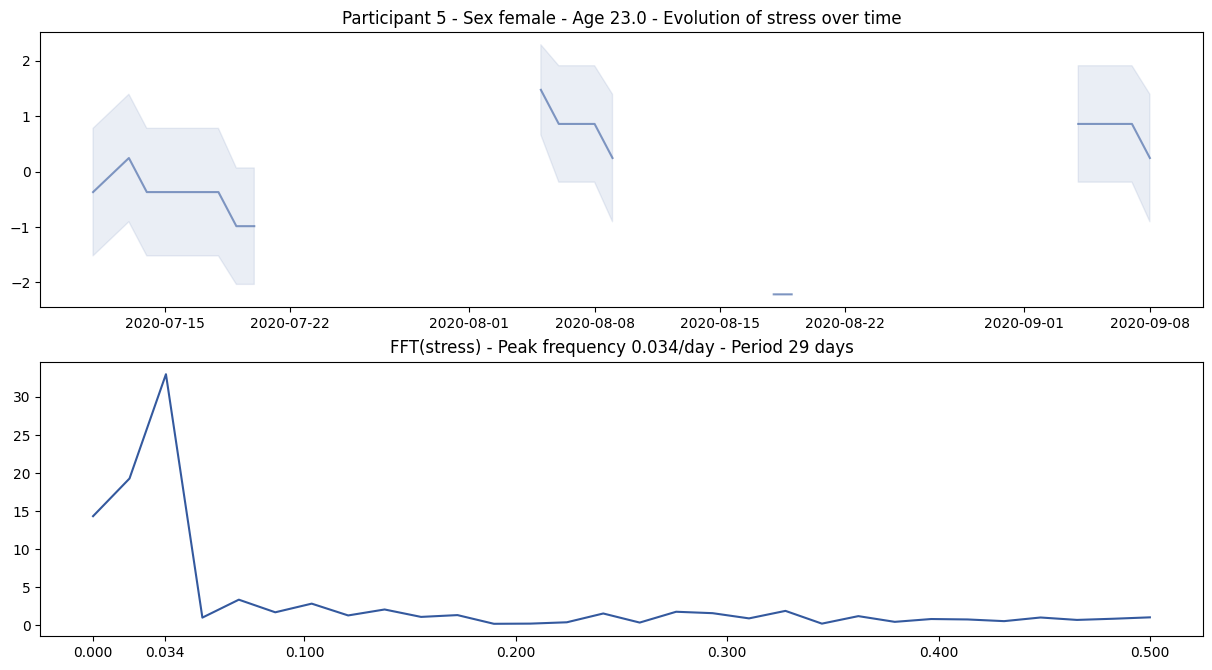

<Figure size 1400x300 with 0 Axes>

29.0

In [10]:
k = 5
participant = females[k]
#participant = 'U-J8E38GJFGUJBMY7HFQ4V'

pdf = df.loc[df.participant_id == participant]
gender = pdf.gender.values[0]
age = pdf.age.values[0]

print(f'Participant {k} - Sex {gender} - Age {age}')

colors = {
    'HR': evi_purple, 'HRV': evi_blue, 'RR': evi_green, 'temperature': evi_orange, "stress":evi_blue, "shifts":evi_blue
}


fig, ax = plt.subplots(2, figsize=(15, 8), dpi=100)

i = 4
fields = ['HR', 'HRV', 'RR', 'temperature', 'stress', 'shifts']
plt.figure(figsize=(14, 3), dpi=100)
#for field in fields:
field = fields[i]
color = colors[field]
ax[0].plot(pdf.date, pdf['z_rolling_' + field], color=color, alpha=.6)
ax[0].fill_between(pdf.date, pdf['z_rolling_' + field + '_minus'], pdf['z_rolling_' + field + '_plus'], color=color, alpha=.1)
title = f'Participant {k} - Sex {gender} - Age {age} - Evolution of {field} over time'
ax[0].set_title(title)
#plt.show()
i+=1

freq, period, freqs, fft = get_period(pdf['z_rolling_' + field].values)

ax[1].plot(freqs, fft, color=color)
ax[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5] + [round(freq, 3)])
title = f'FFT({field}) - Peak frequency {round(freq, 3)}/day - Period {round(period)} days'
ax[1].set_title(title)
plt.show()
period

In [11]:
period

29.0

# Period distribution across participants

In [12]:
i = 0
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]

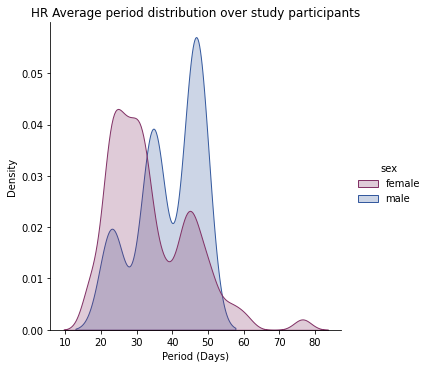

In [13]:
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'HR Average period distribution over study participants')
plt.show()

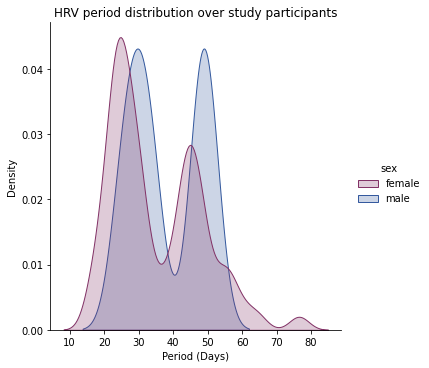

In [14]:
i = 1
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'HRV period distribution over study participants')
plt.show()

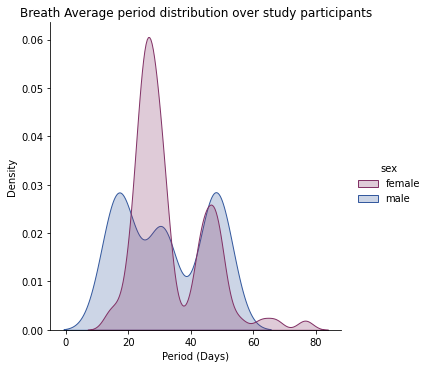

In [15]:
i = 2
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'Breath Average period distribution over study participants')
plt.show()

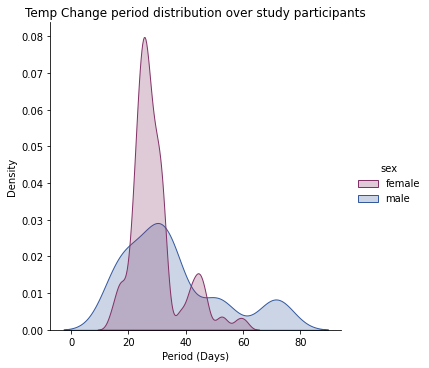

In [16]:
i = 3
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'Temp Change period distribution over study participants')
plt.show()

/h/snagaraj/.conda/envs/stressrecov/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


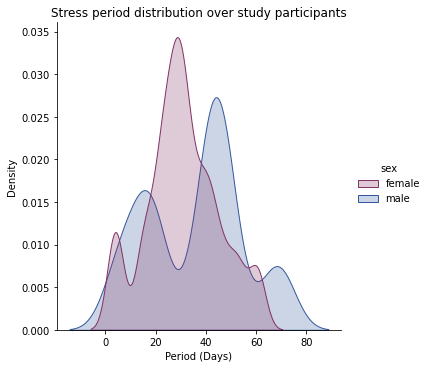

In [17]:
i = 4
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'Stress period distribution over study participants')
plt.show()

/h/snagaraj/.conda/envs/stressrecov/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


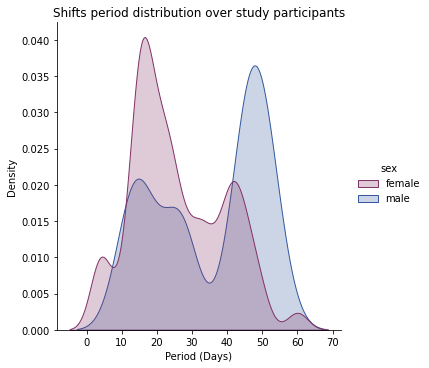

In [18]:
i = 5
field = fields[i]
color = colors[field]
period_df = df.groupby(['participant_id', 'gender', 'age']).agg(
    period=(f'z_rolling_{field}', lambda x: get_period(x)[1])
).reset_index()
period_df["len"] = df.groupby(['participant_id']).size().values
period_df['half_len'] = period_df.apply(lambda x: x.len/2, axis=1)
period_df = period_df.rename(columns={'gender': 'sex'})
period_df = period_df.loc[period_df.period <= period_df.half_len]
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
plt.xlabel('Period (Days)')
plt.title(f'Shifts period distribution over study participants')
plt.show()

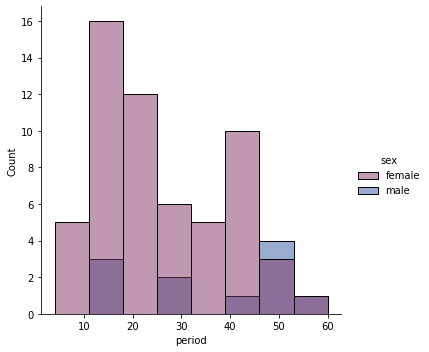

In [19]:
sns.displot(data=period_df, x='period', hue='sex', palette=[evi_purple, evi_blue],
             fill=True, common_norm=False,
            height=5, aspect=1)

In [20]:
df.groupby(['participant_id']).size()

participant_id
U-11YJYE852QXSR8AUC2W1     96
U-1DV1Y8WJ5MD3WEFER4M8    112
U-1GPMFTVN6JZLK4G5UKFA     94
U-1LYJJEEUERAGTXBVXSUH    100
U-1M1PWFRM99UKVZBE4JN8     98
                         ... 
U-YQEHZM1ZP3XCSHVBP11V    159
U-YT5AF8GSQA3WKACCU6H8    138
U-YT5KT8PRFYA1TDSQYQEA     95
U-YY1J4CAB6VNDKUFHJ99E    119
U-Z3HNZ1T74AS7NBBHS2MP    130
Length: 151, dtype: int64

# Recoded

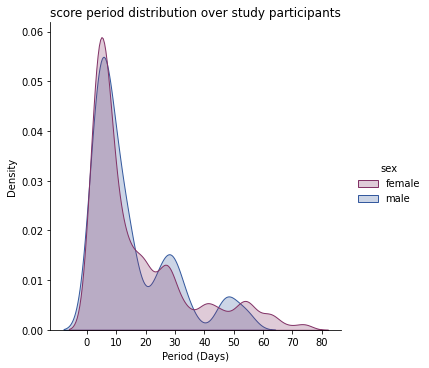

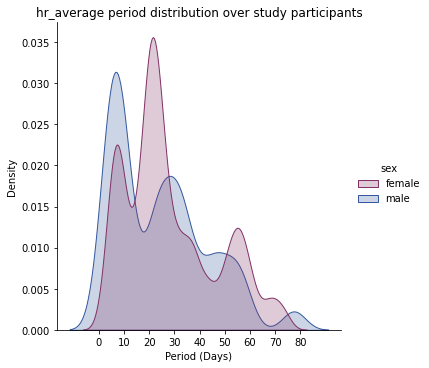

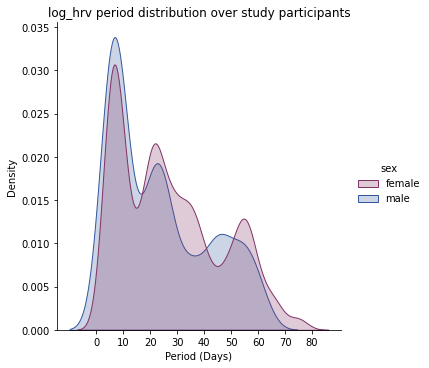

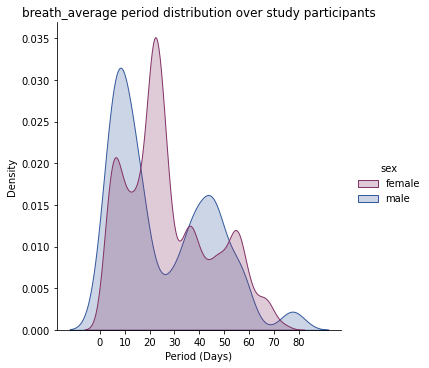

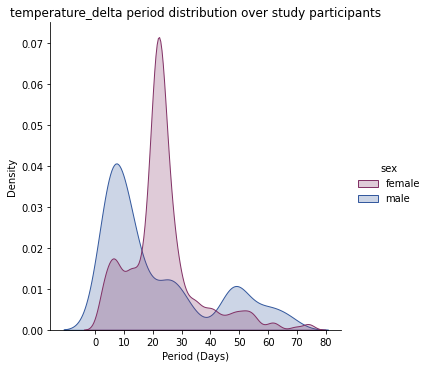

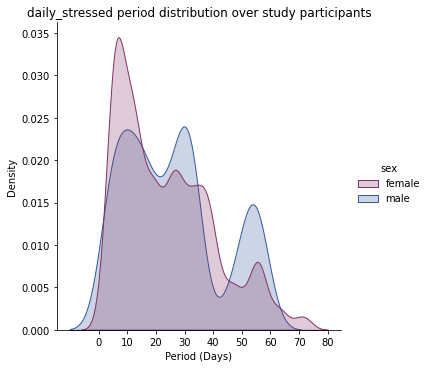

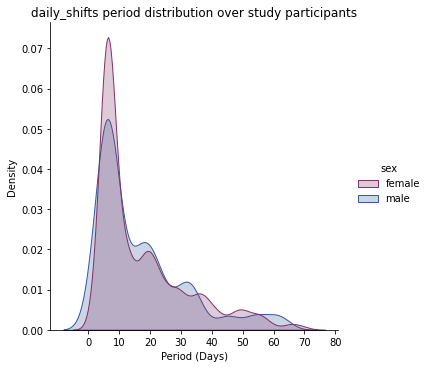

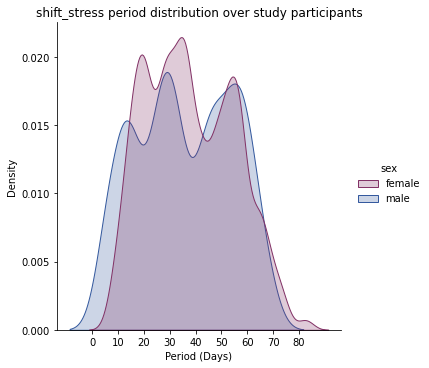

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

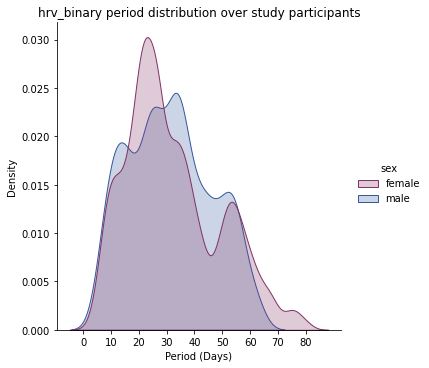

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

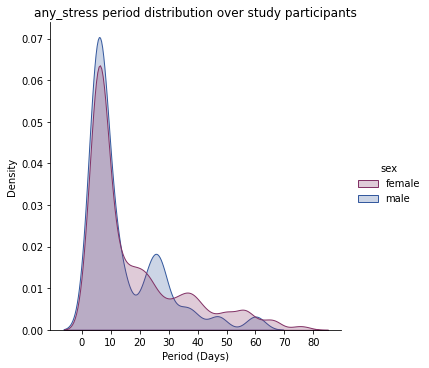

In [22]:

#Get the most common period below the cutoff (<= 1/2 duration)
def get_period_cutoff(s):
    # s: signal, daily timeseries
    # returns:
    # freq: peak frequency
    # period = 1/freq
    # freqs
    # fft
    try:
        s = interpolate(s)
        fs = 1
        freqs = np.fft.rfftfreq(len(s), 1/fs)
        freqs = freqs[1:] #first one is always 0 so skip it
        fft = np.abs(np.fft.rfft(s))

        freq = freqs[np.argmax(fft)]
        periods = 1/freqs

        indices = np.argwhere(periods <= len(s)/2)
        periods_restricted = periods[indices]
        fft_restricted = fft[indices]
        peak_period = periods_restricted[np.argmax(fft_restricted)]
        return peak_period[0]
    except:
        return None
    
#Only keep period if below the cutoff (<= 1/2 duration), otherwise None
def get_period_2(s):
    # s: signal, daily timeseries
    # returns:
    # freq: peak frequency
    # period = 1/freq
    # freqs
    # fft
    try:
        s = interpolate(s)
        fs = 1
        freqs = np.fft.rfftfreq(len(s), 1/fs)
        freqs = freqs[1:] #first one is always 0 so skip it
        fft = np.abs(np.fft.rfft(s))

        freq = freqs[np.argmax(fft)]
        period = 1/freq
        if period <= len(s)/2:
            return period
        else:
            return None
    except:
        return None




df = load_sleep_daily()

dem_df = load_once()
dem_df = dem_df.dropna(subset=['dem_gender'])
dem_df['gender'] = dem_df.dem_gender.apply(lambda x: ['female', 'male', 'non-binary', 'other', 'prefer not to say'][int(x)-1])
dem_df['age'] = dem_df.dem_age
df = df.merge(dem_df[['participant_id', 'gender', 'age']], on='participant_id')

features = ['score', 'hr_average', 'log_hrv', 'breath_average', 'temperature_delta', 'daily_stressed', 'daily_shifts', 'shift_stress', 'hrv_binary', "any_stress"]
no_stress_cutoff = 0.25
stress_cutoff = 0.75
cutoff = 10

participant_list = df.participant_id.unique().tolist()

for feature in features:
    peak_periods = []
    genders = []
    for p in (participant_list):
        df1 = fetch_participant_df(df, p)
        
        if len(df1)<cutoff:
            continue

        #add stress definitions
        if feature == "hrv_binary":
            df1 = hrv_binarize(df1, stress_cutoff, no_stress_cutoff)
        elif feature == "any_stress":
            df1 = hrv_binarize(df1, stress_cutoff, no_stress_cutoff)
            df1 = any_stress(df1)


        #Add missing rows
        df1 = missing_rows(df1)


        #Z Score Normalize
        df1 = z_score(df1, [feature])

        #interpolate missing values
        df1 = lin_interp_multiple(df1, [feature])

        #if anything still missing, fill with column mean
        df1[feature] = df1[feature].fillna(df1[feature].mean())
        
        
        peak_periods.append(get_period_2(df1[feature].values))
        genders.append(df1.gender[0])
    period_df = {"period": peak_periods, "sex":genders}
    period_df = pd.DataFrame.from_dict(period_df)
    
    sns.displot(data=period_df, x='period', hue='sex',palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
    plt.xlabel('Period (Days)')
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
    plt.title(feature+' period distribution over study participants')
    plt.show()
    

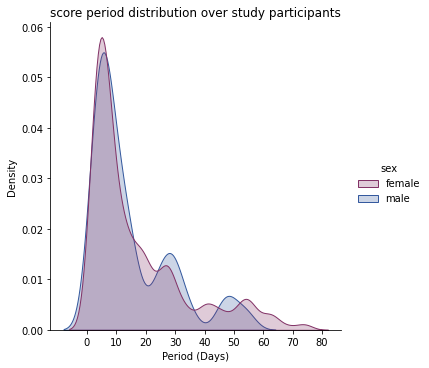

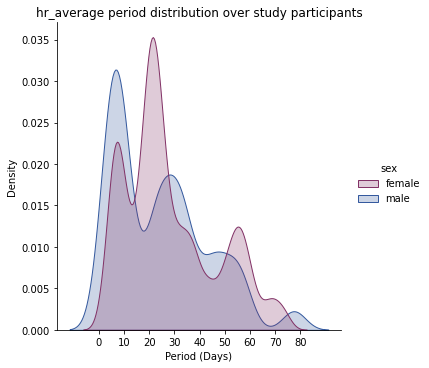

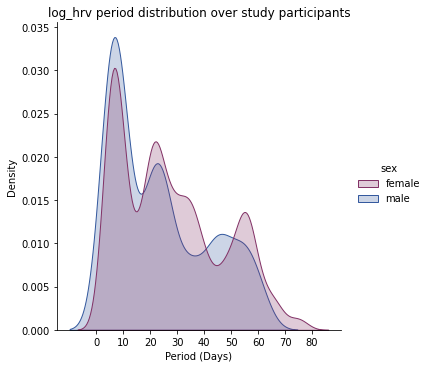

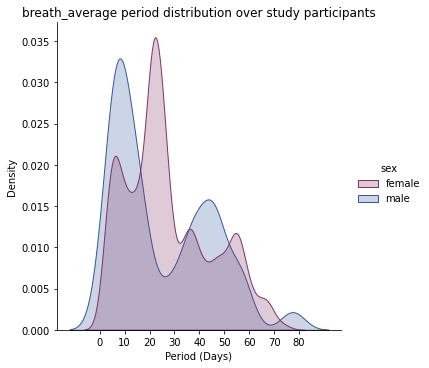

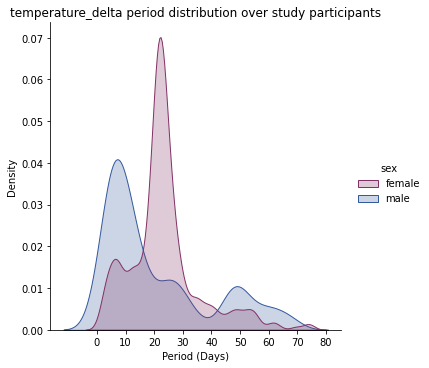

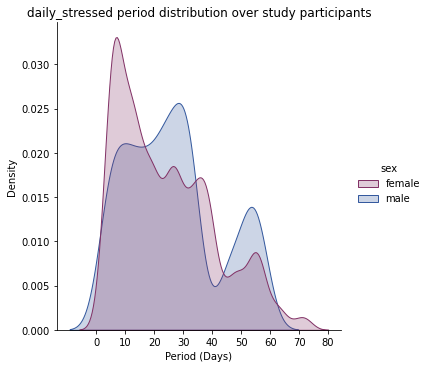

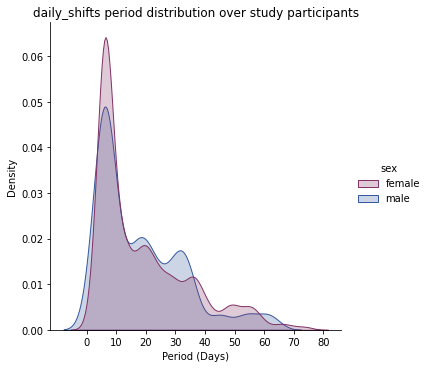

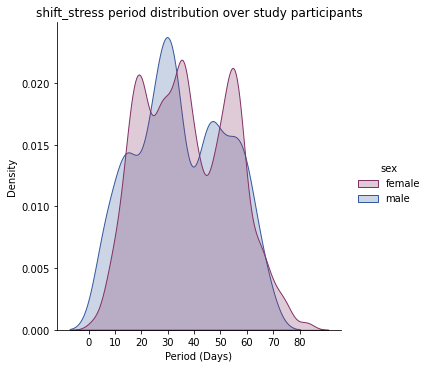

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)


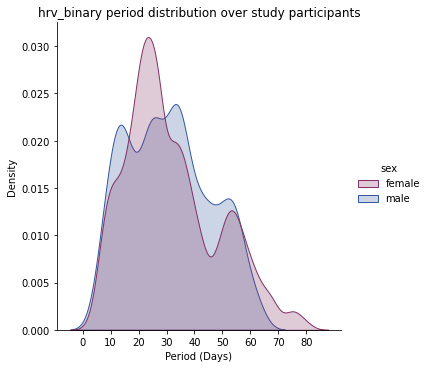

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["any_stress"] = df.apply (lambda row: any_stress_helper(row.daily_stressed, row.daily_shifts, row.shift_stress, row.hrv_binary), axis=1)
../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

../src/definitions.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hrv_percentile'] = df["log_hrv"].rank(pct = True)
../src/definitions.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hrv_binary"] = df.apply (lambda row: binarize_reverse(row.hrv_percentile, stress_cutoff, no_stress_cutoff), axis=1)
../src/definitions.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

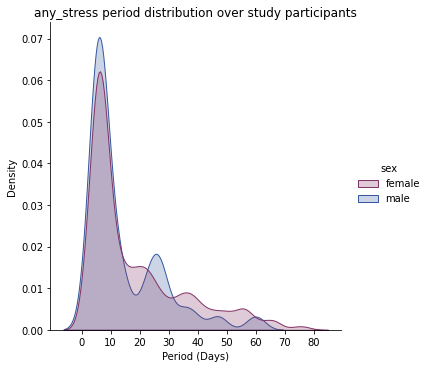

In [23]:
df = load_sleep_daily()

dem_df = load_once()
dem_df = dem_df.dropna(subset=['dem_gender'])
dem_df['gender'] = dem_df.dem_gender.apply(lambda x: ['female', 'male', 'non-binary', 'other', 'prefer not to say'][int(x)-1])
dem_df['age'] = dem_df.dem_age
df = df.merge(dem_df[['participant_id', 'gender', 'age']], on='participant_id')

features = ['score', 'hr_average', 'log_hrv', 'breath_average', 'temperature_delta', 'daily_stressed', 'daily_shifts', 'shift_stress', 'hrv_binary', 'any_stress']
no_stress_cutoff = 0.25
stress_cutoff = 0.75
cutoff = 10

participant_list = df.participant_id.unique().tolist()

for feature in features:
    peak_periods = []
    genders = []
    for p in (participant_list):
        df1 = fetch_participant_df(df, p)
        
        if len(df1)<cutoff:
            continue

        #add stress definitions
        if feature == "hrv_binary":
            df1 = hrv_binarize(df1, stress_cutoff, no_stress_cutoff)
        elif feature == "any_stress":
            df1 = hrv_binarize(df1, stress_cutoff, no_stress_cutoff)
            df1 = any_stress(df1)

        #Add missing rows
        df1 = missing_rows(df1)

        #Z Score Normalize
        df1 = z_score(df1, [feature])

        #interpolate missing values
        df1 = lin_interp_multiple(df1, [feature])

        #if anything still missing, fill with column mean
        df1[feature] = df1[feature].fillna(df1[feature].mean())
        
        peak_periods.append(get_period_cutoff(df1[feature].values))
        genders.append(df1.gender[0])
    period_df = {"period": peak_periods, "sex":genders}
    period_df = pd.DataFrame.from_dict(period_df)
    
    sns.displot(data=period_df, x='period', hue='sex',palette=[evi_purple, evi_blue],
            kind='kde', fill=True, common_norm=False,
            height=5, aspect=1, bw_adjust=0.5)
    plt.xlabel('Period (Days)')
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
    plt.title(feature+' period distribution over study participants')
    plt.show()
    

In [ ]:
s = df1[feature].values


In [ ]:
peak_period

In [ ]:
len(s)

In [ ]:
np.argmax(fft)

In [ ]:
df1.gender[0]

In [ ]:
df1[feature].values

In [ ]:
s= df1[feature].values

s = interpolate(s)
fs = 1
freqs = np.fft.rfftfreq(len(s), 1/fs)
freqs = freqs[1:] #first one is always 0 so skip it
fft = np.abs(np.fft.rfft(s))

freq = freqs[np.argmax(fft)]
periods = 1/freqs

indices = np.argwhere(periods <= len(s)/2)
periods_restricted = periods[indices]
fft_restricted = fft[indices]
peak_period = periods_restricted[np.argmax(fft_restricted)][0]

In [ ]:
peak_period

In [ ]:
peak_period